# Optimizing Word Lookup for NPMI

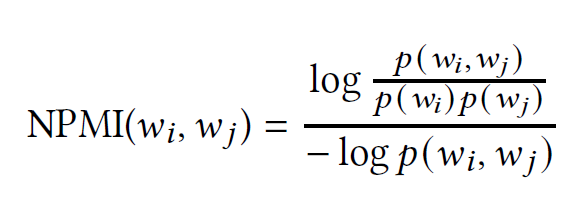

NPMI is a common technique for extracting word co-occurance information from a text corpus. NPMI is also used in calculating topic coherence in topics models, by computing co-occurance between each of the top-10 words (45 pairs).

This notebook compares 4 techniques for NPMI calculation for combinations of words:
- Vanilla NPMI
- Vanilla NPMI with memoing
- Matrix-based NPMI with memoing
- Sparse matrix-based with memoing

In [46]:
import gensim.downloader as api
import json
import pickle
from itertools import combinations
import math
import time
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

Downloading wikipedia dump. Only first 100k articles were used to save memory and speed up computations

In [47]:
info = api.info()
model = api.load('wiki-english-20171001')
texts = []
for i,entry in enumerate(model):
    txt = " ".join(entry['section_texts']).lower().split() # preprocess
    texts.append(txt)
    if i == 0 or i % 10000 == 0:
        print(f"Document {i}")
    if i > 100000: # only preprocess first 100k articles
        break
# save progress
dbfile = open('wiki_dump_raw', 'wb')
pickle.dump(texts, dbfile)
dbfile.close()

Document 0
Document 10000
Document 20000
Document 30000
Document 40000
Document 50000
Document 60000
Document 70000
Document 80000
Document 90000
Document 100000


In [48]:
texts[0][:10]

["'''anarchism'''",
 'is',
 'a',
 'political',
 'philosophy',
 'that',
 'advocates',
 'self-governed',
 'societies',
 'based']

FREQ is used in NPMI calculation

In [49]:
# total # of words in wiki
FREQ = sum([len(doc) for doc in texts])
print(FREQ)

184076171


In [50]:
# vanilla NPMI implementation
def vanilla_npmi(wi, wj, wiki_corpus):
    p_wi = p_wj = p_wi_wj = 0
    for doc in wiki_corpus:
        if wi in doc:
            p_wi += 1
        if wj in doc:
            p_wj += 1
        if wi in doc and wj in doc:
            p_wi_wj += 1
            
    p_wi /= FREQ
    p_wj /= FREQ
    p_wi_wj /= FREQ
    
    numer = math.log(p_wi_wj / (p_wi * p_wj))
    denom = -math.log(p_wi_wj, 2)
    return numer / denom

In [74]:
# NPMI with memoing
# trading space complexity for time complexity
def npmi_memoing(wi, wj, wiki_corpus, keywords_counts):
    def count_word(w, wiki_corpus):
        w_ct = 0
        w_idx = []
        for i, doc in enumerate(wiki_corpus):
            if w in doc:
                w_ct += 1
                w_idx.append(i)
        keywords_counts[w] = (w_ct, w_idx)
        
    # count word occurance if not in keywords_counts
    if wi not in keywords_counts and wj not in keywords_counts:
        wi_ct = 0
        wi_idx = []
        wj_ct = 0
        wj_idx = []
        for i, doc in enumerate(wiki_corpus):
            if wi in doc:
                wi_ct += 1
                wi_idx.append(i)
            if wj in doc:
                wj_ct += 1
                wj_idx.append(i)
        keywords_counts[wi] = (wi_ct, wi_idx)
        keywords_counts[wj] = (wj_ct, wj_idx)
    elif wi not in keywords_counts:
        count_word(wi, wiki_corpus)
    elif wj not in keywords_counts:
        count_word(wj, wiki_corpus)
            
    # count both
    p_wi_wj = len(set(set(keywords_counts[wi][1]) & set(keywords_counts[wj][1])))
        
    if p_wi_wj == 0: # they never occur together
        return -1.0
    else:
        p_wi = keywords_counts[wi][0]
        p_wj = keywords_counts[wj][0]
        
        p_wi /= FREQ
        p_wj /= FREQ
        p_wi_wj /= FREQ

        numer = math.log(p_wi_wj / (p_wi * p_wj))
        denom = -math.log(p_wi_wj)
        return numer / denom

In [52]:
# NPMI matrix with memoing
# trading space for time even more
v = CountVectorizer(binary=True, dtype=np.int8, min_df=2)

X = v.fit_transform([" ".join(txt) for txt in texts]) # csr matrix
X_dense = X.todense() # dense matrix

features = v.get_feature_names()

In [106]:
# regular matrix
def matrix_npmi(wi, wj, X, keywords_counts_matrix, features):
    if wi not in keywords_counts_matrix:
        wi_idx = features.index(wi)
        wi_mt = X[:, wi_idx].A.flatten()
        keywords_counts_matrix[wi] = wi_mt
    else:
        wi_mt = keywords_counts_matrix[wi]
        
    if wj not in keywords_counts_matrix:
        wj_idx = features.index(wj)
        wj_mt = X[:, wj_idx].A.flatten()
        keywords_counts_matrix[wj] = wj_mt
    else:
        wj_mt = keywords_counts_matrix[wj]
        
    p_wi = wi_mt.sum()
    p_wj = wj_mt.sum()
    p_wi_wj = ((wi_mt == 1) & (wi_mt == wj_mt)).sum() 
    
    p_wi /= FREQ
    p_wj /= FREQ
    p_wi_wj /= FREQ

    numer = math.log(p_wi_wj / (p_wi * p_wj))
    denom = -math.log(p_wi_wj)
    return numer / denom

Generating 10 random words (45 pairs) for evaluation

In [54]:
# random words were generated from https://randomwordgenerator.com/
keywords = ['skill', 'explanation', 'mud', 'height', 'beer', 'flight', 'fortune', 'honey', 'childhood', 'device']

## Evaluation

In [89]:
# testing for different number of word combinations

X_size = X_dense.size * X_dense.itemsize #len(pickle.dumps(X_dense)) # space overhead for the matrix
X_csr_size = len(pickle.dumps(X)) # sparse

# lists with results
time_vanilla = []
space_vanilla = [0] * len(range(2, len(new_words)+1)) #constant

time_memo = []
space_memo = []

time_mt = []
space_mt = []

time_mt_sparse = []
space_mt_sparse = []

for i in range(2, len(new_words)+1):
    combs = list(combinations(new_words[:i], 2))
    print(f"Calculating for {i} words: {len(combs)} word combinations")
    
    # vanilla npmi
    t_start_vanilla = time.time()
    for c in combs:
        vanilla_npmi(c[0], c[1], texts)
    t_end_vanilla = time.time()
    time_vanilla.append(t_end_vanilla - t_start_vanilla)
    
    # memo npmi
    t_start_memo = time.time()
    keywords_counts = {}
    for c in combs:
        npmi_memoing(c[0], c[1], texts, keywords_counts)
    t_end_memo = time.time()
    time_memo.append(t_end_memo - t_start_memo)
    space_memo.append(len(pickle.dumps(keywords_counts))) # trick to calculate size of object
    
    # matrix
    t_start_mt = time.time()
    keywords_counts_matrix = {}
    for c in combs:
        matrix_npmi(c[0], c[1], X_dense, keywords_counts_matrix)
    t_end_mt = time.time()
    time_mt.append(t_end_mt - t_start_mt)
    space_mt.append(len(pickle.dumps(keywords_counts_matrix)) + X_size) # original matrix size always adds up
    
    # sparse matrix
    t_start_mt_sparse = time.time()
    keywords_counts_matrix_sparse = {}
    for c in combs:
        matrix_npmi(c[0], c[1], X, keywords_counts_matrix_sparse)
    t_end_mt_sparse = time.time()
    time_mt_sparse.append(t_end_mt_sparse - t_start_mt_sparse)
    space_mt_sparse.append(len(pickle.dumps(keywords_counts_matrix_sparse)) + X_csr_size)

Calculating for 2 words: 1 word combinations
Calculating for 3 words: 3 word combinations
Calculating for 4 words: 6 word combinations
Calculating for 5 words: 10 word combinations
Calculating for 6 words: 15 word combinations
Calculating for 7 words: 21 word combinations
Calculating for 8 words: 28 word combinations
Calculating for 9 words: 36 word combinations
Calculating for 10 words: 45 word combinations


## Plotting

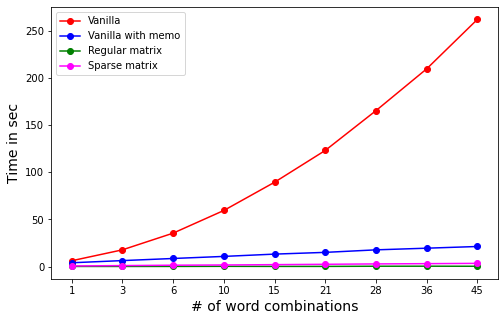

In [90]:
x_labels = [0] + [math.comb(i, 2) for i in range(2, len(new_words)+1)]

fig,ax = plt.subplots(figsize=(8,5))

a1, = ax.plot(time_vanilla, color="red", marker="o", label='Vanilla')
a2, = ax.plot(time_memo, color="blue", marker="o", label='Vanilla with memo')
a3, = ax.plot(time_mt, color="green", marker="o", label='Regular matrix')
a4, = ax.plot(time_mt_sparse, color="magenta", marker="o", label='Sparse matrix')

ax.set_xticklabels(x_labels)
ax.set_xlabel("# of word combinations", fontsize=14)
ax.set_ylabel("Time in sec", fontsize=14)

plt.legend(loc='upper left', handles=[a1, a2, a3, a4])
plt.show()

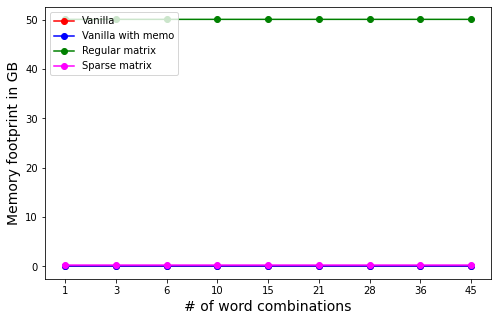

In [91]:
space_vanilla_gb = list(map(lambda x: x / 1024 / 1024 / 1024, space_vanilla)) # GB
space_memo_gb = list(map(lambda x: x / 1024 / 1024 / 1024, space_memo))
space_mt_gb = list(map(lambda x: x / 1024 / 1024 / 1024, space_mt))
space_mt_sparse_gb = list(map(lambda x: x / 1024 / 1024 / 1024, space_mt_sparse))

fig,ax = plt.subplots(figsize=(8,5))

a1, = ax.plot(space_vanilla_gb, color="red", marker="o", label='Vanilla')
a2, = ax.plot(space_memo_gb, color="blue", marker="o", label='Vanilla with memo')
a3, = ax.plot(space_mt_gb, color="green", marker="o", label='Regular matrix')
a4, = ax.plot(space_mt_sparse_gb, color="magenta", marker="o", label='Sparse matrix')

ax.set_xticklabels(x_labels)
ax.set_xlabel("# of word combinations", fontsize=14)
ax.set_ylabel("Memory footprint in GB", fontsize=14)

plt.legend(loc='upper left', handles=[a1, a2, a3, a4])
plt.show()

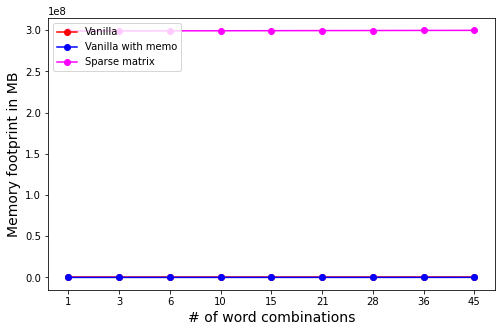

In [92]:
space_vanilla_mb = list(map(lambda x: x / 1024 / 1024, space_vanilla)) # GB
space_memo_mb = list(map(lambda x: x / 1024 / 1024, space_memo))
space_mt_sparse_mb = list(map(lambda x: x / 1024 / 1024, space_mt_sparse))

fig,ax = plt.subplots(figsize=(8,5))

a1, = ax.plot(space_vanilla, color="red", marker="o", label='Vanilla')
a2, = ax.plot(space_memo, color="blue", marker="o", label='Vanilla with memo')
#a3, = ax.plot(space_mt, color="green", marker="o", label='Regular matrix')
a4, = ax.plot(space_mt_sparse, color="magenta", marker="o", label='Sparse matrix')

ax.set_xticklabels(x_labels)
ax.set_xlabel("# of word combinations", fontsize=14)
ax.set_ylabel("Memory footprint in MB", fontsize=14)

plt.legend(loc='upper left', handles=[a1, a2, a4])
plt.show()

In [ ]:
x_labels = [0] + [math.comb(i, 2) for i in range(2, len(new_words)+1)]

fig,ax = plt.subplots()

l1, = ax.plot(time_vanilla, color="red", marker="o", label='Vanilla (time)')
l2, = ax.plot(time_memo, color="blue", marker="o", label='Memoing (time)')
ax.set_xticklabels(x_labels)
ax.set_xlabel("# of word combinations")
ax.set_ylabel("Time in sec", fontsize=14)

ax2 = ax.twinx()
l3, = ax2.plot([0] * (len(x_labels)-1), color="red", marker="x", label='Vanilla (space)')
l4, = ax2.plot(space_memo, color="blue", marker="x", label='Memoing (space)')
ax2.set_ylabel("Space complexity", fontsize=14)

plt.legend(loc='upper left', handles=[l1, l3, l2, l4])

plt.show()

## Vanilla vs. Memoing

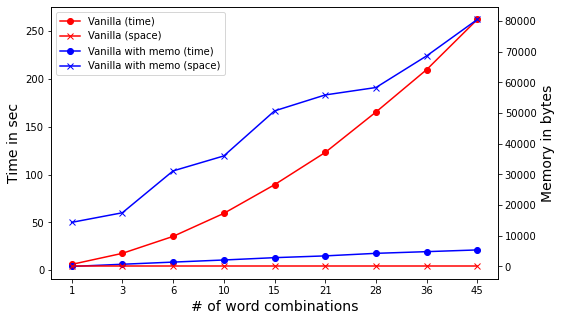

In [97]:
x_labels = [0] + [math.comb(i, 2) for i in range(2, len(new_words)+1)]

fig,ax = plt.subplots(figsize=(8,5))

a1, = ax.plot(time_vanilla, color="red", marker="o", label='Vanilla (time)')
a2, = ax.plot(time_memo, color="blue", marker="o", label='Vanilla with memo (time)')

ax.set_xticklabels(x_labels)
ax.set_xlabel("# of word combinations", fontsize=14)
ax.set_ylabel("Time in sec", fontsize=14)

ax2 = ax.twinx()
a3, = ax2.plot(space_vanilla, color="red", marker="x", label='Vanilla (space)')
a4, = ax2.plot(space_memo, color="blue", marker="x", label='Vanilla with memo (space)')
ax2.set_ylabel("Memory in bytes", fontsize=14)

plt.legend(loc='upper left', handles=[a1, a3, a2, a4])
plt.show()

## Sparse vs. Dense

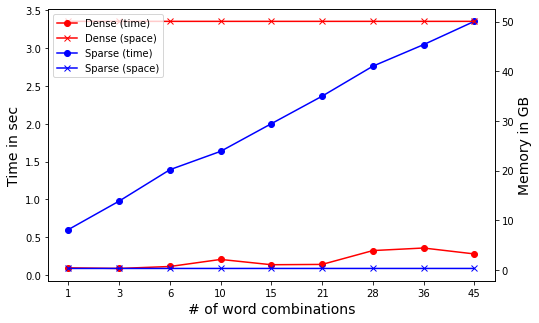

In [99]:
x_labels = [0] + [math.comb(i, 2) for i in range(2, len(new_words)+1)]

fig,ax = plt.subplots(figsize=(8,5))

a1, = ax.plot(time_mt, color="red", marker="o", label='Dense (time)')
a2, = ax.plot(time_mt_sparse, color="blue", marker="o", label='Sparse (time)')

ax.set_xticklabels(x_labels)
ax.set_xlabel("# of word combinations", fontsize=14)
ax.set_ylabel("Time in sec", fontsize=14)

ax2 = ax.twinx()
a3, = ax2.plot(space_mt_gb, color="red", marker="x", label='Dense (space)')
a4, = ax2.plot(space_mt_sparse_gb, color="blue", marker="x", label='Sparse (space)')
ax2.set_ylabel("Memory in GB", fontsize=14)

plt.legend(loc='upper left', handles=[a1, a3, a2, a4])
plt.show()

## Calculating NPMI using the whole Wikipedia dump

In [100]:
wiki_corpus_size = 2531105734 # precomputed
from scipy import sparse
wiki_matrix = sparse.load_npz("C:\\wiki\\wiki_dump_binary_matrix.npz")
with open("C:\\wiki\\features.txt", 'r', encoding='utf-8') as f:
    wiki_features = f.readlines()
wiki_features = [feature.strip() for feature in wiki_features]

In [107]:
wiki_matrix_size = len(pickle.dumps(wiki_matrix))

time_mt_sparse_whole = []
space_mt_sparse_whole = []

for i in range(2, len(new_words)+1):
    combs = list(combinations(new_words[:i], 2))
    print(f"Calculating for {i} words: {len(combs)} word combinations")
    
    # sparse matrix
    t_start_mt_sparse = time.time()
    keywords_counts_matrix_sparse_whole = {}
    for c in combs:
        matrix_npmi(c[0], c[1], wiki_matrix, keywords_counts_matrix_sparse_whole, wiki_features)
    t_end_mt_sparse = time.time()
    time_mt_sparse_whole.append(t_end_mt_sparse - t_start_mt_sparse)
    space_mt_sparse_whole.append(len(pickle.dumps(keywords_counts_matrix_sparse_whole)) + wiki_matrix_size)

Calculating for 2 words: 1 word combinations
Calculating for 3 words: 3 word combinations
Calculating for 4 words: 6 word combinations
Calculating for 5 words: 10 word combinations
Calculating for 6 words: 15 word combinations
Calculating for 7 words: 21 word combinations
Calculating for 8 words: 28 word combinations
Calculating for 9 words: 36 word combinations
Calculating for 10 words: 45 word combinations


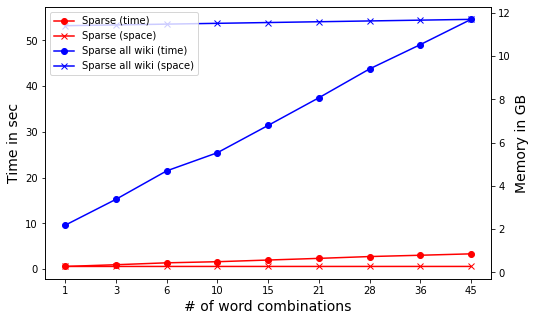

In [112]:
space_mt_sparse_whole_gb = list(map(lambda x: x / 1024 / 1024 / 1024,  space_mt_sparse_whole))

x_labels = [0] + [math.comb(i, 2) for i in range(2, len(new_words)+1)]

fig,ax = plt.subplots(figsize=(8,5))

a1, = ax.plot(time_mt_sparse, color="red", marker="o", label='Sparse (time)')
a2, = ax.plot(time_mt_sparse_whole, color="blue", marker="o", label='Sparse all wiki (time)')

ax.set_xticklabels(x_labels)
ax.set_xlabel("# of word combinations", fontsize=14)
ax.set_ylabel("Time in sec", fontsize=14)

ax2 = ax.twinx()
a3, = ax2.plot(space_mt_sparse_gb, color="red", marker="x", label='Sparse (space)')
a4, = ax2.plot(space_mt_sparse_whole_gb, color="blue", marker="x", label='Sparse all wiki (space)')
ax2.set_ylabel("Memory in GB", fontsize=14)

plt.legend(loc='upper left', handles=[a1, a3, a2, a4])
plt.show()